# Original Paper: Sparse Identification of Nonlinear Dynamical systems (SINDy)

This notebook uses PySINDy to reproduce the example systems from the paper "[Discovering governing equations from data: Sparse identification of nonlinear dynamical systems](https://www.pnas.org/content/113/15/3932)". We provide some mathematical background regarding each example in this notebook and suggest looking to the original paper for further details.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import odeint
from scipy.io import loadmat
from pysindy.utils import linear_damped_SHO, cubic_damped_SHO, linear_3D, hopf, lorenz

import pysindy as ps

## Simple illustrative systems
Here we give examples of SINDy applied to simple linear and nonlinear dynamical systems. In each instance the `SINDy` object is given measurements of state variables, but not their derivatives, and is tasked with identifying the equations to describe their dynamics.

### Linear 2D ODE

The first example shows a demonstration of SINDy on a linear two-dimensional damped harmonic oscillator.

We generate training data by integrating the following linear system of differential equations with initial condtion $(2,0)$.

$$ \frac{d}{dt} \begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix} -0.1 & 2 \\ -2 & -0.1 \end{bmatrix} \begin{bmatrix}x \\ y\end{bmatrix} $$

In [2]:
# Generate training data

dt = 0.01
t_train = np.arange(0, 25, dt)
x0_train = [2, 0]
x_train = odeint(linear_damped_SHO, x0_train, t_train)

Next we fit a SINDy model to the training data, finding that it recovers the correct governing equations.

In [3]:
# Fit the model

poly_order = 5
threshold = 0.05

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
)
model.fit(x_train, t=dt)
model.print()

(x0)' = -0.100 x0 + 2.000 x1
(x1)' = -2.000 x0 + -0.100 x1


The learned model can be used to evolve initial conditions forward in time. Here we plot the trajectories predicted by the SINDy model against those of the true governing equations.

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


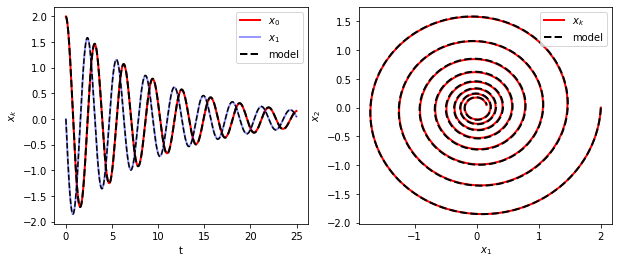

In [4]:
# Simulate and plot the results

x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
axs[0].plot(t_train, x_train[:, 1], "b", label="$x_1$", alpha=0.4, **plot_kws)
axs[0].plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
axs[0].plot(t_train, x_sim[:, 1], "k--")
axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x_k$")

axs[1].plot(x_train[:, 0], x_train[:, 1], "r", label="$x_k$", **plot_kws)
axs[1].plot(x_sim[:, 0], x_sim[:, 1], "k--", label="model", **plot_kws)
axs[1].legend()
axs[1].set(xlabel="$x_1$", ylabel="$x_2$")
fig.show()

### Cubic 2D ODE

SINDy can also identify a *nonlinear* two-dimensional damped harmonic oscillator. This example involves cubic dynamics. The governing system used to generate training data is as follows. It is identical to the previous example except the linear terms in the right-hand side have been replaced with cubic ones.

$$ \frac{d}{dt}\begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix}-0.1 & 2 \\ -2 & -0.1 \end{bmatrix} \begin{bmatrix}x^3 \\ y^3\end{bmatrix} $$

In [5]:
# Generate training data

dt = 0.01
t_train = np.arange(0, 25, dt)
x0_train = [2, 0]
x_train = odeint(cubic_damped_SHO, x0_train, t_train)

In [6]:
# Fit the model

poly_order = 5
threshold = 0.05

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
)
model.fit(x_train, t=dt)
model.print()

(x0)' = -0.100 x0^3 + 1.999 x1^3
(x1)' = -1.999 x0^3 + -0.100 x1^3


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


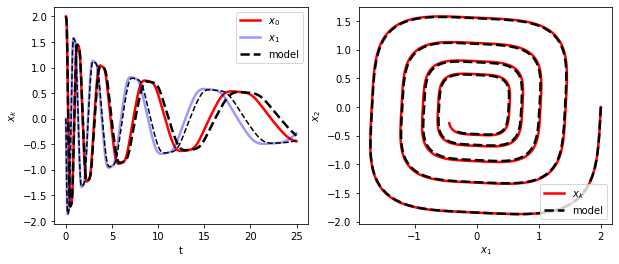

In [7]:
# Simulate and plot the results

x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2.5)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
axs[0].plot(t_train, x_train[:, 1], "b", label="$x_1$", alpha=0.4, **plot_kws)
axs[0].plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
axs[0].plot(t_train, x_sim[:, 1], "k--")
axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x_k$")

axs[1].plot(x_train[:, 0], x_train[:, 1], "r", label="$x_k$", **plot_kws)
axs[1].plot(x_sim[:, 0], x_sim[:, 1], "k--", label="model", **plot_kws)
axs[1].legend()
axs[1].set(xlabel="$x_1$", ylabel="$x_2$")
fig.show()

### Linear 3D ODE

Our final example of this section shows the application of SINDy to identify of a linear system in three dimensions. The governing equations are given by the following system.

$$ \frac{d}{dt}\begin{bmatrix}x \\ y \\ z \end{bmatrix} = \begin{bmatrix}-0.1 & -2 & 0 \\ 2 & -0.1 & 0 \\ 0 & 0 & -0.3 \end{bmatrix} \begin{bmatrix}x \\ y \\ z \end{bmatrix} $$

In [8]:
# Generate training data

dt = .01
t_train = np.arange(0, 50, dt)
x0_train = [2, 0, 1]
x_train = odeint(linear_3D, x0_train, t_train)

In [9]:
# Fit the model

poly_order = 5
threshold = 0.01

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)
model.fit(x_train, t=dt)
model.print()

(x0)' = -0.100 x0 + 2.000 x1
(x1)' = -2.000 x0 + -0.100 x1
(x2)' = -0.300 x2


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


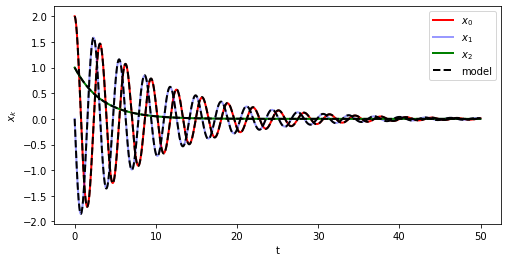

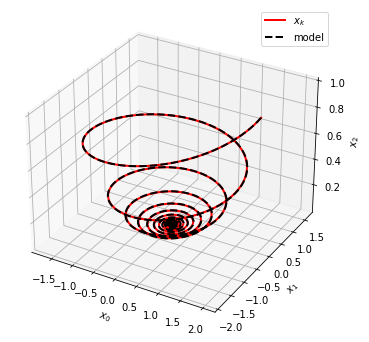

In [10]:
# Simulate and plot the results

x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)

fig = plt.figure(figsize=(8, 4))
plt.plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
plt.plot(t_train, x_train[:, 1], "b", label="$x_1$", alpha=0.4, **plot_kws)
plt.plot(t_train, x_train[:, 2], "g", label="$x_2$", **plot_kws)
plt.plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
plt.plot(t_train, x_sim[:, 1], "k--", **plot_kws)
plt.plot(t_train, x_sim[:, 2], "k--", **plot_kws)
plt.legend()
plt.xlabel("t")
plt.ylabel("$x_k$")
fig.show()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "r", label="$x_k$", **plot_kws)
ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="model", **plot_kws)
ax.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$")
ax.legend()
fig.show()

## Lorenz system (nonlinear ODE)

The Lorenz system serves as an example of a nonlinear ODE whose solutions exhibit chaotic dynamics evolving on a strange attractor. The Lorenz system is given by

$$ \begin{aligned} \dot x &= \sigma(y-x)\\ \dot y &= x(\rho - z) - y \\ \dot z &= xy - \beta z, \end{aligned} $$

with $\sigma=10$, $\rho=28$, and $\beta=\tfrac{8}{3}$ for this example. We generate our training data starting from the initial condition $(-8, 8, 27)$. Note that for this example we also collect measurements of derivatives of state variables, $(\dot x, \dot y, \dot z)$.

In [11]:
# Generate training data

dt = 0.001
t_train = np.arange(0, 100, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)
x_dot_train_measured = np.array(
    [lorenz(x_train[i], 0) for i in range(t_train.size)]
)

### Measure states $x$ and derivatives $\dot{x}$

In this example, both the states $x$ and derivatives $\dot{x}$ of the Lorenz system are measures, and increasing levels of noise ($\eta$) are added to the derivatives.

In [12]:
# Fit the models and simulate

poly_order = 5
threshold = 0.05
seed = 100
np.random.seed(seed)  # Seed for reproducibility

noise_levels = [1e-4, 1e-3, 1e-2, 1e-1, 1.0]

models = []
t_sim = np.arange(0, 20, dt)
x_sim = []
for eps in noise_levels:
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold),
        feature_library=ps.PolynomialLibrary(degree=poly_order),
    )
    model.fit(
        x_train,
        t=dt,
        x_dot=x_dot_train_measured
        + np.random.normal(scale=eps, size=x_train.shape),
        quiet=True,
    )
    models.append(model)
    x_sim.append(model.simulate(x_train[0], t_sim))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


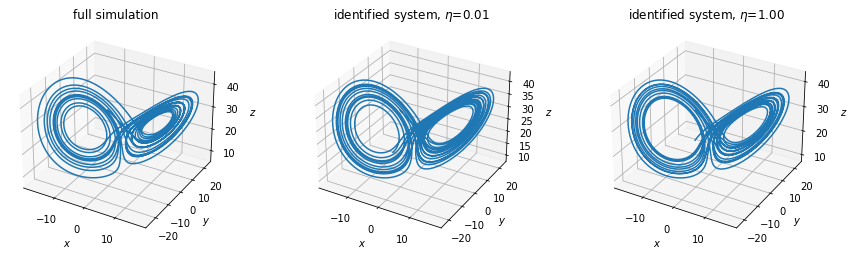

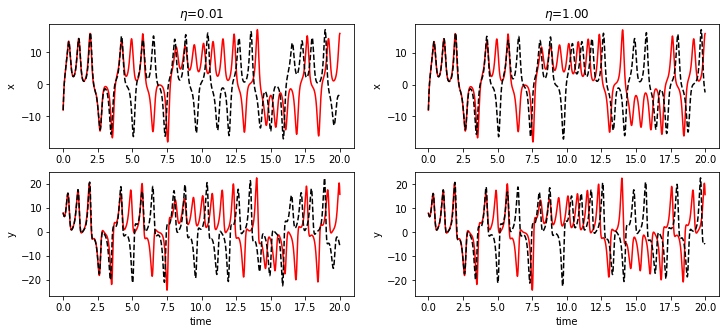

In [13]:
# Plot results

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_train[: t_sim.size, 0],
    x_train[: t_sim.size, 1],
    x_train[: t_sim.size, 2],
)
plt.title("full simulation")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 2
ax = fig.add_subplot(132, projection="3d")
ax.plot(x_sim[model_idx][:, 0], x_sim[model_idx][:, 1], x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 4
ax = fig.add_subplot(133, projection="3d")
ax.plot(x_sim[model_idx][:, 0], x_sim[model_idx][:, 1], x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

fig = plt.figure(figsize=(12, 5))
model_idx = 2
ax = fig.add_subplot(221)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(223)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

model_idx = 4
ax = fig.add_subplot(222)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(224)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

fig.show()

### Measure only the states $x$, compute the derivatives

In this example, only the states $x$ are measured and noise at different levels is added to the states. Derivatives are computed from the noisy state measurements using a centered difference scheme.

In [14]:
# Fit the models and simulate

noise_levels = [1e-4, 1e-3, 1e-2, 1e-1, 1.0]

models_noD = []
t_sim = np.arange(0, 20, dt)
x_sim_noD = []
for eps in noise_levels:
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold),
        feature_library=ps.PolynomialLibrary(degree=poly_order),
    )
    model.fit(x_train + np.random.normal(scale=eps, size=x_train.shape), t=dt, quiet=True)
    models_noD.append(model)
    x_sim_noD.append(model.simulate(x_train[0], t_sim))

### Compare the errors in each case

Here we plot the error as a function of time for varying levels of noise.

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


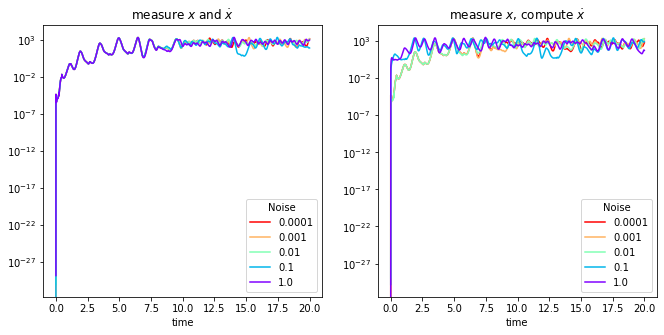

In [15]:
colors = rainbow(np.linspace(1, 0, len(models)))

fig, axs = plt.subplots(1, 2, figsize=(11, 5))
for i, x in enumerate(x_sim):
    axs[0].semilogy(
        t_sim,
        np.sum((x - x_train[: t_sim.size]) ** 2, axis=1),
        color=colors[i],
        label=noise_levels[i],
    )
axs[0].set(xlabel="time", title="measure $x$ and $\dot{x}$")
axs[0].legend(title="Noise")

for i, x in enumerate(x_sim_noD):
    axs[1].semilogy(
        t_sim,
        np.sum((x - x_train[: t_sim.size]) ** 2, axis=1),
        color=colors[i],
        label=noise_levels[i],
    )

axs[1].set(xlabel="time", title="measure $x$, compute $\dot{x}$")
axs[1].legend(title="Noise")

fig.show()

## Fluid wake behind a cylinder (nonlinear PDE)

This example demonstrates the application of SINDy to a high-dimensional nonlinear partial differential equation. The two-dimensional Navier-Stokes equations are simulated to generate state measurements for fluid flow past a cylinder at Reynolds number 100. The proper orthogonal decomposition (POD) is applied to the high-dimensional state measurements (with dimensionality determined by the number of grid points in the simulation) to get a low-dimensional representation of the dynamics. SINDy is then applied to the dynamics in the first three POD modes.

In [16]:
# Load training data

dt = 0.02
r = 2
n = r + 1

data_run1 = loadmat("data/PODcoefficients.mat")
x_run1 = np.concatenate(
    (data_run1["alpha"][:5000, :r], data_run1["alphaS"][:5000, 0:1]), axis=1
)
t_run1 = np.arange(0, dt * x_run1.shape[0], dt)

data_run2 = loadmat("data/PODcoefficients_run1.mat")
x_run2 = np.concatenate(
    (data_run2["alpha"][:3000, :r], data_run2["alphaS"][:3000, 0:1]), axis=1
)
t_run2 = np.arange(0, dt * x_run2.shape[0], dt)

x_train = [x_run1, x_run2]
t_train = [t_run1, t_run2]

In [17]:
# Fit the model

optimizer = ps.STLSQ(threshold=1e-4)
library = ps.PolynomialLibrary(degree=5)
model = ps.SINDy(
    optimizer=optimizer, feature_library=library, feature_names=["x", "y", "z"]
)
model.fit(x_train, t_train, multiple_trajectories=True, quiet=True)
model.print()

(x)' = -0.133 1 + -0.009 x + -1.023 y + -0.001 z + -0.002 y z
(y)' = -0.057 1 + 1.035 x + 0.005 y + 0.002 x z + -0.002 y z
(z)' = -20.653 1 + -0.294 z + 0.001 x^2 + 0.001 y^2 + -0.001 z^2


In [18]:
# Simulate the model

x_simulate_run1 = model.simulate(x_run1[0], np.arange(0, 100, 0.02))
x_simulate_run2 = model.simulate(x_run2[0], np.arange(0, 95, 0.02))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


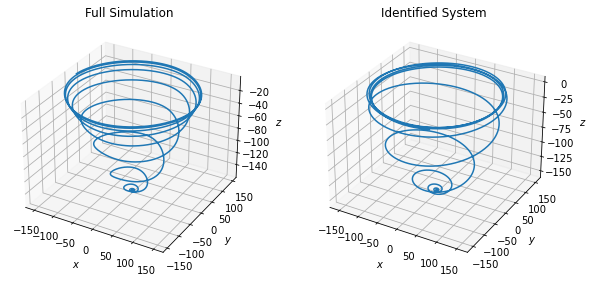

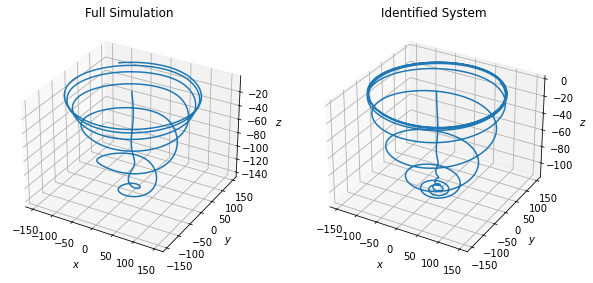

In [19]:
# Plot results

fig = plt.figure(figsize=(10, 4.5))
ax = fig.add_subplot(121, projection="3d")
ax.plot(x_run1[:, 0], x_run1[:, 1], x_run1[:, 2])
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
plt.title("Full Simulation")

ax = fig.add_subplot(122, projection="3d")
ax.plot(x_simulate_run1[:, 0], x_simulate_run1[:, 1], x_simulate_run1[:, 2])
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
plt.title("Identified System")

fig = plt.figure(figsize=(10, 4.5))
ax = fig.add_subplot(121, projection="3d")
ax.plot(x_run2[:, 0], x_run2[:, 1], x_run2[:, 2])
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
plt.title("Full Simulation")

ax = fig.add_subplot(122, projection="3d")
ax.plot(x_simulate_run2[:, 0], x_simulate_run2[:, 1], x_simulate_run2[:, 2])
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
plt.title("Identified System")
fig.show()

## Bifurcations and normal forms

The examples in this section demonstate the ability of SINDy to incorporate parameterized dynamical systems (e.g. normal forms associated with a bifurcation parameter). Note that the parameter, $\mu$, in these examples is embedded in the dynamics as a variable

$$ \begin{aligned} \dot{\mathbf{x}} &= \mathbf{f}(\mathbf{x};\mu) \\ \dot\mu &= 0. \end{aligned} $$

whose value can the be recovered with SINDy.

We demonstrate this procedure with two examples: the 1D logistic map and the 2D Hopf normal form.

### Logistic map

This is a *discrete time* example that exhibits several bifurcations.

Discrete time systems require a slightly different treatment than the previous systems. We consider discrete systems of the following form

$$ x_{k+1} = f(x_k). $$

To apply SINDy to discrete-time problems, one forms the two data matrices $X_1^{m-1}$ and $X_2^m$, given by

$$ X_1^{m-1} = \begin{bmatrix} - & x_1^\top & - \\ - & x_2^\top & - \\ & \vdots & \\ - & x_{m-1}^\top & - \\ \end{bmatrix}, \qquad X_2^{m} = \begin{bmatrix} - & x_2^\top & - \\ - & x_3^\top & - \\ & \vdots & \\ - & x_{m}^\top & - \\ \end{bmatrix}. $$

The original sparse regression problem is then supplanted by

$$ X_2^m \approx \Theta\left(X_1^{m-1}\right)\Xi. $$

The dynamics of the **logistic map** are described by

$$ x_{k+1} = \mu x_k(1-x_k) + \eta_k, $$

where $\mu$ is the bifurcation parameter and $\eta_k\sim N(0, 10^{-3})$ is a (normally distributed) stochastic forcing parameter.

We collect training data consisting of 1000 steps of the logistic map with 10 different values of $\mu$; $\mu\in\{2.5,  2.75, 3, 3.25, 3.5, 3.75, 3.8, 3.85, 3.9, 3.95\}$.

In [20]:
# Generate training data

N = 1000
mus = [2.5, 2.75, 3, 3.25, 3.5, 3.75, 3.8, 3.85, 3.9, 3.95]
eps = 0.025
x = [np.zeros((N, 2)) for i in range(len(mus))]
for i, mu in enumerate(mus):
    x[i][0] = [0.5, mu]
    for k in range(1, N):
        x[i][k, 0] = np.maximum(
            np.minimum(
                mu * x[i][k - 1, 0] * (1 - x[i][k - 1, 0])
                + eps * np.random.randn(),
                1.0,
            ),
            0.0,
        )
        x[i][k, 1] = mu
x_train = x

Fitting a SINDy model (with `discrete_time=True`), we find that the underlying dynamics are accurately recovered. Note that we do not attempt to capture the stochastic forcing, merely the denoised model.

In [21]:
# Fit the model

optimizer = ps.STLSQ(threshold=0.1)
library = ps.PolynomialLibrary(degree=5)
model = ps.SINDy(
    optimizer=optimizer, feature_library=library, discrete_time=True
)
model.fit(x_train, multiple_trajectories=True)
model.print()

(x0)[k+1] = 0.773 x0[k] + 0.245 x0[k] x1[k] + -2.474 x0[k]^3 + 0.145 x0[k] x1[k]^2 + 0.649 x0[k]^3 x1[k] + -0.262 x0[k]^2 x1[k]^2
(x1)[k+1] = 1.000 x1[k]


We test the performance of the learned model by applying it to generate predictions for multiple values of $1\leq\mu\leq4$.

In [22]:
# Generate test data (with stochastic forcing)

mus = np.arange(1, 4, 0.01)
x_test = np.zeros((mus.size * N, 2))
idx = 0
for mu in mus:
    xold = 0.5
    for i in range(N):
        xnew = np.maximum(
            np.minimum(
                mu * xold - mu * xold ** 2 + eps * np.random.randn(), 1.0
            ),
            0.0,
        )
        xold = xnew
    xss = xnew
    for i in range(N):
        xnew = np.maximum(
            np.minimum(
                mu * xold - mu * xold ** 2 + eps * np.random.randn(), 1.0
            ),
            0.0,
        )
        xold = xnew
        x_test[idx, 0] = xnew
        x_test[idx, 1] = mu
        idx += 1
        if np.abs(xnew - xss) < 0.001:
            break
x_test = x_test[:idx]

In [23]:
# Simulate on test data

x_sim = np.zeros((mus.size * N, 2))
idx = 0
for mu in mus:
    xss = model.simulate([0.5, mu], N)[-1]
    stop_condition = lambda x: np.abs(x[0] - xss[0]) < 0.001
    x = model.simulate(xss, N, stop_condition=stop_condition)
    idx_new = idx + x.shape[0]
    x_sim[idx:idx_new] = x
    idx = idx_new
x_sim = x_sim[:idx]

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


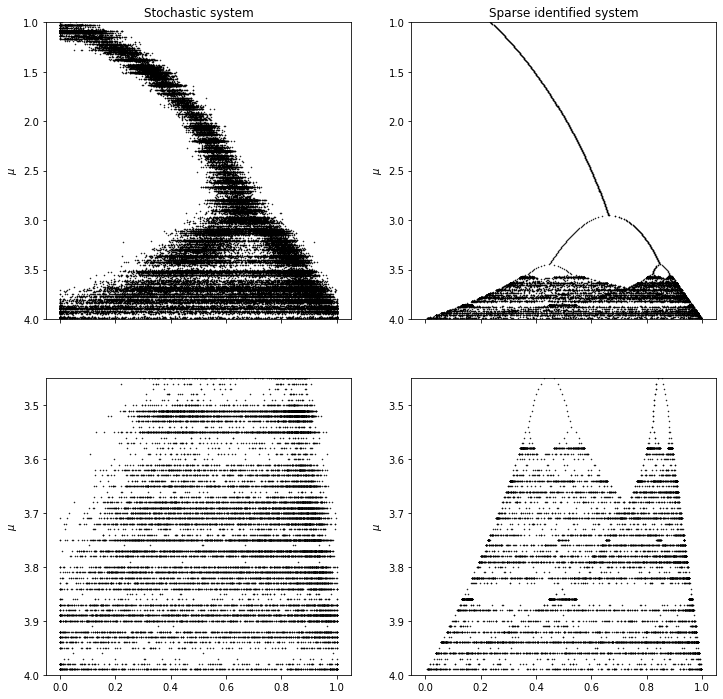

In [24]:
# Plot results

fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharex=True)

axs[0, 0].plot(x_test[:, 0], x_test[:, 1], "k.", markersize=1)
axs[0, 0].set(
    title="Stochastic system",
    ylabel="$\mu$",
    ylim=[4, 1]
)

axs[1, 0].plot(x_test[:, 0], x_test[:, 1], "k.", markersize=1)
axs[1, 0].set(ylabel="$\mu$", ylim=[4, 3.45])

axs[0, 1].plot(x_sim[:, 0], x_sim[:, 1], "k.", markersize=1)
axs[0, 1].set(
    title="Sparse identified system",
    ylabel="$\mu$",
    ylim=[4, 1]
)

axs[1, 1].plot(x_sim[:, 0], x_sim[:, 1], "k.", markersize=1)
axs[1, 1].set(ylabel="$\mu$", ylim=[4, 3.45])

fig.show()

Notice that, despite the large amount of noise present in the stochastically forced system from which measurements are taken, SINDy is able to closely approximate the (denoised) underlying model. This is due, at least in part, to the fact that no derivatives need to be computed.

### Hopf normal form

This example shows the identification of the Hopf normal form, which is a parameterized normal form in continuous time.

We collect noisy data from the Hopf system

$$ \begin{aligned} \dot x &= \mu x + \omega y - Ax(x^2 + y^2) \\ \dot y &= -\omega x + \mu y - Ay(x^2 + y^2), \end{aligned} $$

with different values of the bifurcation parameter $\mu$ (fixing $\omega=A=1$).

As in the previous example $\mu$ is incorporated into the model discovery process by introducing a third equation

$$ \dot \mu = 0. $$

If $\mu<0$ then a (stable) fixed point occurs at $(x,y)=(0,0)$ and if $\mu>0$ then a (stable) limit cycle occurs on the circle $x^2+y^2 = \mu$ instead. We test SINDy using two negative values and six positive values of $\mu$.

In [25]:
# Generate training data

omega = 1
A = 1

dt = 0.0025
t_train = np.arange(0, 75, dt)

mu_stable = np.array([-0.15, -0.05])
mu_unstable = np.array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55])

n_ics = mu_stable.size + 2 * mu_unstable.size
x_train = [np.zeros((t_train.size, 3)) for i in range(n_ics)]
eps = 0.001
ic_idx = 0

for mu in mu_stable:
    x0_train = [2, 0]
    x = odeint(lambda x, t: hopf(x, mu, omega, A), x0_train, t_train)
    x_train[ic_idx][:, 0:2] = x + eps * np.random.normal(size=x.shape)
    x_train[ic_idx][:, 2] = mu
    ic_idx += 1

for mu in mu_unstable:
    x0_train = [0.01, 0]
    x = odeint(lambda x, t: hopf(x, mu, omega, A), x0_train, t_train)
    x_train[ic_idx][:, 0:2] = x + eps * np.random.normal(size=x.shape)
    x_train[ic_idx][:, 2] = mu
    ic_idx += 1

    x0_train = [2, 0]
    x = odeint(lambda x, t: hopf(x, mu, omega, A), x0_train, t_train)
    x_train[ic_idx][:, 0:2] = x + eps * np.random.normal(size=x.shape)
    x_train[ic_idx][:, 2] = mu
    ic_idx += 1

In [26]:
# Fit the model

optimizer = ps.STLSQ(threshold=0.85)
library = ps.PolynomialLibrary(degree=5)
model = ps.SINDy(optimizer=optimizer, feature_library=library)
model.fit(x_train, t=dt, multiple_trajectories=True, quiet=True)
model.print()

(x0)' = 1.008 x0 + -1.000 x1 + -1.008 x0^3 + -1.008 x0 x1^2
(x1)' = 1.000 x0 + 0.999 x1 + -0.999 x0^2 x1 + -0.999 x1^3
(x2)' = 0.000


In [27]:
# Simulate the model

x_sim = [np.zeros((t_train.size, 3)) for i in range(n_ics)]
ic_idx = 0

for mu in mu_stable:
    x0_train = np.array([2, 0, mu])
    x_sim[ic_idx] = model.simulate(x0_train, t_train)
    ic_idx += 1

for mu in mu_unstable:
    x0_train = np.array([0.01, 0, mu])
    x_sim[ic_idx] = model.simulate(x0_train, t_train)
    ic_idx += 1

    x0_train = np.array([2, 0, mu])
    x_sim[ic_idx] = model.simulate(x0_train, t_train)
    ic_idx += 1

Blue trajectories show the evolution of initial conditions starting outside the limit cycle for $\mu>0$ or away from the fixed point for $\mu<0$. Red ones correspond to initial conditions inside the limit cycle.

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


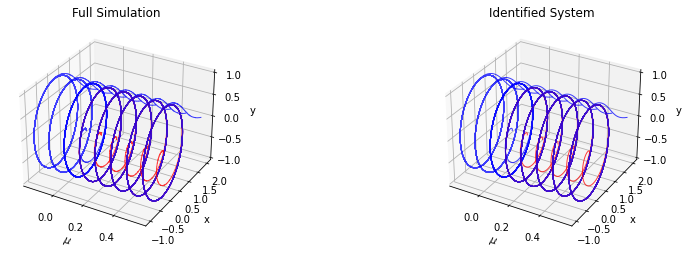

In [28]:
# Plot results

fig = plt.figure(figsize=(14, 4))
plot_kws=dict(alpha=0.75, linewidth=1)

ax = fig.add_subplot(121, projection="3d")
for i in range(n_ics):
    if i > 2 and i % 2 == 0:
        ax.plot(
            x_train[i][:, 2], x_train[i][:, 0], x_train[i][:, 1], "r", **plot_kws)
    else:
        ax.plot(x_train[i][:, 2], x_train[i][:, 0], x_train[i][:, 1], "b", **plot_kws)

ax.set(title="Full Simulation", xlabel="$\mu$", ylabel="x", zlabel="y")

ax = fig.add_subplot(122, projection="3d")
for i in range(n_ics):
    if i > 2 and i % 2 == 0:
        ax.plot(x_sim[i][:, 2], x_sim[i][:, 0], x_sim[i][:, 1], "r", **plot_kws)
    else:
        ax.plot(x_sim[i][:, 2], x_sim[i][:, 0], x_sim[i][:, 1], "b", **plot_kws)
ax.set(title="Identified System", xlabel="$\mu$", ylabel="x", zlabel="y")

fig.show()